# Pytorch Integration
This example demonstrates how to train and use an MParT-based transport map 
in a larger pytorch model.  To illustrate, a regression problem with heteroscedastic
noise will be considered.  

The goal of this problem is to characterize a conditional distribution $p(y|x)$,
where $x,y\in\mathbb{R}$.  To characterize this distribution, we will construct 
a conditional transport map of the form $T(y; f(x))$, where $f:\mathbb{R}\rightarrow\mathbb{R}^M$
is a feature extractor that returns an $M$ dimensional vector.  This feature extractor 
will be defined with a neural network (pytorch) while the map itself $T:\mathbb{R}^{M+1}\rightarrow\mathbb{R}$
is defined with a polynomial-based monotone map (MParT).

In [1]:
import matplotlib.pyplot as plt
import torch
import mpart as mt

## Generate Training Data 

In [2]:
num_pts = 1000
x_train = torch.linspace(-2.0*torch.pi, 2.0*torch.pi, num_pts, dtype=torch.double)
y_true = torch.sin(x_train)
y_train = y_true + 0.5*torch.abs(1.0+torch.cos(x_train))*torch.randn(num_pts)

In [3]:
dataset = torch.utils.data.TensorDataset(x_train.reshape(-1,1), y_train.reshape(-1,1)) 
dataloader = torch.utils.data.DataLoader(dataset, batch_size=128, shuffle=True)
num_epochs = 200

##  Define the hybrid model

In [4]:
maxDegree = 3 # <- The maximum total order of the map $T$
tgt_dim = 1 # <- The dimension of the target random variable $y$
cond_dim = 2 # <- The number of features $M$ returned by the neural network

#### MParT map Construction
Here we construct the 3->1 dimensional map in the typical fashion of MParT but 
using options that help make the map robust to inputs.

In [5]:
opts = mt.MapOptions()
opts.basisLB = -2.5
opts.basisUB = 2.5
opts.nugget = 0.001
tmap = mt.CreateTriangular(cond_dim+tgt_dim, tgt_dim, maxDegree, opts) # Simple third order map

#### Hybrid Construction
We can now create a torch model for the composition $T(y; f(x))$.  The `.torch()` function
from the MParT map returns a torch.nn.Module that can be used as a native pytorch object.
The autograd functionality in pytorch can also be used with this function.

In [6]:
class MapModel(torch.nn.Module):
    def __init__(self, tmap):
        super().__init__()
        self.linear1 = torch.nn.Linear(1, 300, dtype=torch.double)
        self.activation = torch.nn.LeakyReLU()
        self.linear2 = torch.nn.Linear(300, cond_dim, dtype=torch.double)
        self.tmap = tmap.torch(return_logdet=True)

    def forward(self, x, y):
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)

        x = torch.hstack([x,y])
        r, logdet = self.tmap.forward(x)

        return r, logdet

    def inverse(self, x, r):
        """ This is an additional function for computing the inverse of $T$ to compute $y$ from $r$.
        """
        x = self.linear1(x)
        x = self.activation(x)
        x = self.linear2(x)
        x = torch.hstack([x,r])

        y = self.tmap.inverse(x,r)

        return y

In [7]:
model = MapModel(tmap)

## Train the model
Here we use the negative log likelihood as a training function.

Given a value of $x$, the hybrid function $r=T(y; f(x))$ defines a monotone transformation
that can be used to transform probability distributions.  By assuming the distribution 
of $r$ is $\mu_r$, we can define a map-induced distribution over $y$ given by the pull back
of the reference measure $\mu_r$ through the map: $\mu_y=T^{\sharp}\mu_r$.  The log density of this 
distribution is proportinoal to $\log p( T(y; f(x)) ) + \log \text{det}\nabla_y T$, where $
$p(r)$ is the density of the reference distribution.  To compute the parameters of the map and 
the weights of the neural network, we will maximize the likelihood of the training data according
to this map-induced density and the assumption that $p(r)=N(0,1)$ is standard normal.

In [8]:
model.train()
optimizer = torch.optim.Adam(model.parameters(), lr=7e-3)
num_epochs = 200
for epoch in range(num_epochs):
    for i, data in enumerate(dataloader):
        
        x_batch, y_batch = data

        ref, logdet = model.forward(x_batch, y_batch)

        # Zero your gradients for every batch!
        optimizer.zero_grad()

        # Evaluate the map and its log determinant for this batch
        ref, logdet = model(x_batch, y_batch)

        # Compute the negative log likelihood as a loss function
        loss = -torch.mean(-ref*ref + logdet)  # <- proportional to negative log likelihood with standard normal reference distribution
        loss.backward()

        # Adjust learning weights
        optimizer.step()

        if (i % 200) == 0:
            print(f'Loss: {loss.item():0.4e}')

Loss: 7.6801e-01
Loss: 7.7617e-01
Loss: 7.0297e-01
Loss: 6.7936e-01
Loss: 7.2891e-01
Loss: 8.9034e-01
Loss: 6.2427e-01
Loss: 5.5826e-01
Loss: 5.8599e-01
Loss: 5.8602e-01
Loss: 4.4136e-01
Loss: 5.1315e-01
Loss: 4.1918e-01


Loss: 4.6694e-01
Loss: 2.0278e-01
Loss: 1.9866e-01
Loss: 2.7430e-01
Loss: 1.5499e-01
Loss: 2.0071e-01
Loss: 4.0289e-01
Loss: 2.9684e-01
Loss: 2.6376e-01
Loss: 6.1140e-02
Loss: 2.8270e-01
Loss: 1.5353e-01


Loss: 1.6224e-01
Loss: 7.5834e-02
Loss: -8.5355e-02
Loss: 1.3005e-02
Loss: 1.2101e-01
Loss: -1.6678e-02
Loss: -1.1464e-01
Loss: 1.3441e-01
Loss: 2.6340e-01
Loss: 2.2625e-01
Loss: 9.0673e-02
Loss: -2.9305e-02
Loss: -1.4802e-01


Loss: 8.4184e-02
Loss: 2.4859e-01
Loss: 1.4857e-01
Loss: -1.9226e-02
Loss: -1.0103e-02
Loss: 2.2712e-02
Loss: 9.3784e-03
Loss: -3.8232e-02
Loss: 4.6317e-02
Loss: 2.7935e-02
Loss: 8.3293e-03
Loss: -6.0486e-03
Loss: 8.5765e-02


Loss: 2.0941e-01
Loss: -4.4750e-03
Loss: 6.6646e-02
Loss: 2.7198e-02
Loss: -1.2189e-01
Loss: 1.8143e-01
Loss: 7.1587e-02
Loss: -5.6588e-02
Loss: -1.6923e-01
Loss: -3.1521e-02
Loss: -1.5366e-02
Loss: -4.1281e-02
Loss: 2.7798e-03


Loss: 2.0583e-01
Loss: 1.8847e-02
Loss: -9.9000e-03
Loss: -9.1305e-02
Loss: -7.6757e-02
Loss: -2.2691e-01
Loss: -2.4483e-01
Loss: -1.8737e-01
Loss: -3.9288e-02
Loss: 6.6073e-04
Loss: -5.4151e-02
Loss: 7.6875e-03
Loss: 7.5114e-02


Loss: -1.3502e-01
Loss: -2.1463e-01
Loss: -1.1795e-01
Loss: -7.6602e-02
Loss: -3.1421e-02
Loss: 3.7233e-02
Loss: -1.5410e-01
Loss: -8.4801e-03
Loss: 6.3911e-03
Loss: -5.4655e-02
Loss: -2.1230e-01
Loss: -7.2591e-02
Loss: -3.0607e-02


Loss: -2.4425e-02
Loss: -1.8471e-01
Loss: -5.4069e-02
Loss: -4.9242e-02
Loss: -1.9346e-01
Loss: -1.3517e-01
Loss: 8.2718e-02
Loss: -1.4009e-01
Loss: -6.6510e-02
Loss: -1.7482e-01
Loss: -1.9767e-01
Loss: -7.8380e-02
Loss: -2.0076e-01


Loss: -6.8765e-02
Loss: -5.5146e-02
Loss: 5.3907e-02
Loss: -1.5444e-01
Loss: -2.0441e-01
Loss: -2.9381e-01
Loss: -2.5013e-01
Loss: -1.1882e-01
Loss: -2.5918e-02
Loss: -3.3545e-01
Loss: -1.7899e-01
Loss: 2.0050e-02
Loss: 2.8717e-01


Loss: -2.0615e-01
Loss: -3.0767e-02
Loss: -2.6080e-01
Loss: 1.9694e-02
Loss: -3.6144e-02
Loss: -2.0073e-02
Loss: -2.2839e-01
Loss: -3.4707e-02
Loss: -1.9003e-01
Loss: -2.6475e-01
Loss: -1.0342e-01
Loss: -9.0959e-02
Loss: -2.2555e-01


Loss: -1.9723e-01
Loss: 1.7205e-01
Loss: -1.9143e-01
Loss: 7.9542e-03
Loss: -1.4359e-01
Loss: -1.6865e-01
Loss: -2.5266e-01
Loss: -2.8167e-01
Loss: -2.6886e-02
Loss: -1.4955e-01
Loss: -8.0056e-02
Loss: 8.2114e-02
Loss: -1.1266e-01


Loss: -1.4708e-01
Loss: -2.0735e-01
Loss: 1.8030e-02
Loss: -1.7236e-01
Loss: -5.9715e-02
Loss: -1.4299e-01
Loss: -3.4281e-02
Loss: 3.7946e-02
Loss: -1.4970e-01
Loss: 6.9420e-03
Loss: 3.5806e-02
Loss: -2.1828e-01
Loss: 1.9348e-01


Loss: 1.4925e-01
Loss: 1.6661e-02
Loss: -1.5634e-01
Loss: -3.3538e-02
Loss: -2.7053e-01
Loss: -1.5023e-01
Loss: -1.6094e-01
Loss: 9.2700e-03
Loss: -1.8157e-01
Loss: -1.0306e-01
Loss: -3.2904e-02
Loss: -1.0671e-01
Loss: -1.7445e-01


Loss: -1.5567e-01
Loss: -4.5723e-02
Loss: -1.7352e-01
Loss: -6.5901e-02
Loss: -1.8545e-01
Loss: -9.6030e-04
Loss: -1.6410e-01
Loss: -2.9522e-01
Loss: -2.0978e-01
Loss: -1.3243e-01
Loss: -1.9498e-01
Loss: -8.4890e-02
Loss: -3.2353e-01


Loss: -2.4771e-02
Loss: -9.2343e-02
Loss: -1.9362e-01
Loss: 6.8812e-02
Loss: -1.3094e-01
Loss: -1.2219e-01
Loss: -1.4630e-01
Loss: -4.3322e-02
Loss: 5.8943e-02
Loss: -6.2556e-02
Loss: 1.9589e-01
Loss: -7.3010e-02
Loss: -1.3039e-01


Loss: -1.1592e-01
Loss: -2.6513e-01
Loss: 8.0510e-02
Loss: -4.0881e-02
Loss: 1.1081e-01
Loss: -8.5199e-02


Now that we've finished training, we can go ahead with plotting

In [9]:
# ## Plot the results
model.eval()

MapModel(
  (linear1): Linear(in_features=1, out_features=300, bias=True)
  (activation): LeakyReLU(negative_slope=0.01)
  (linear2): Linear(in_features=300, out_features=2, bias=True)
  (tmap): TorchConditionalMapBase()
)

We plot the true function along with the training data accordingly.

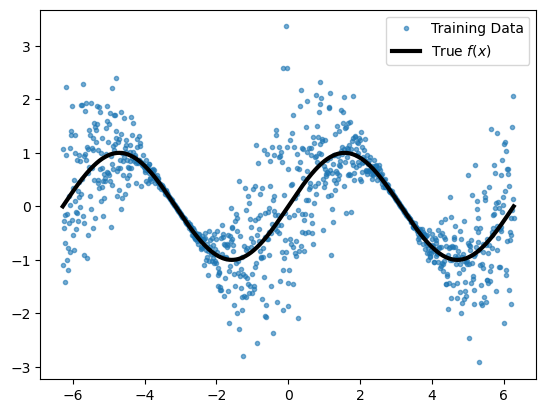

In [10]:
plt.plot(x_train,y_train,'.', label='Training Data',alpha=0.6, zorder=2)
plt.plot(x_train,y_true,'-k',label='True $f(x)$',linewidth=3, zorder=2)
plt.legend()

In [11]:
num_plot = 200 
x_plot = torch.linspace(-2.0*torch.pi, 2.0*torch.pi, num_plot, dtype=torch.double).reshape(-1,1)

Since the map is monotone and real-valued, we can find the median and the quantiles directly

In [12]:
# Compute the median.
r = torch.zeros((num_plot,1), dtype=torch.double)
median = model.inverse(x_plot,r)

In [13]:
# Compute the 5% quantile 
r = -2.0*torch.ones((num_plot,1), dtype=torch.double)
q05 = model.inverse(x_plot,r)

In [14]:
# Compute the 95% quantile 
r = 2.0*torch.ones((num_plot,1), dtype=torch.double)
q95 = model.inverse(x_plot,r)

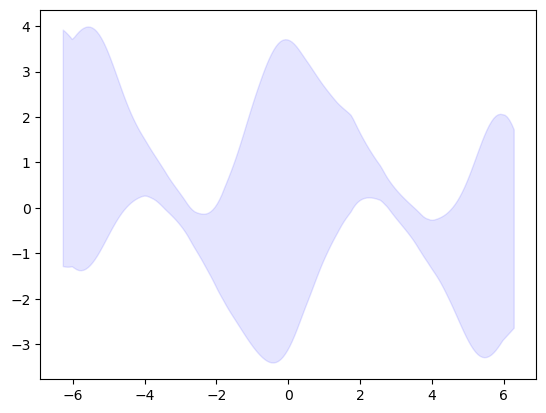

In [15]:
plt.fill_between(x_plot.ravel(),q05.ravel(),q95.ravel(), color='b', alpha=0.1, label='%5-95% CI', zorder=1)

Finally, let's plot the median as well as some realizations of the noise

In [16]:
num_samples_per_point = 10
r = torch.randn((num_plot*num_samples_per_point,1), dtype=torch.double)
xplot_rep = x_plot.repeat(num_samples_per_point, 1)
samples = model.inverse(xplot_rep,r)

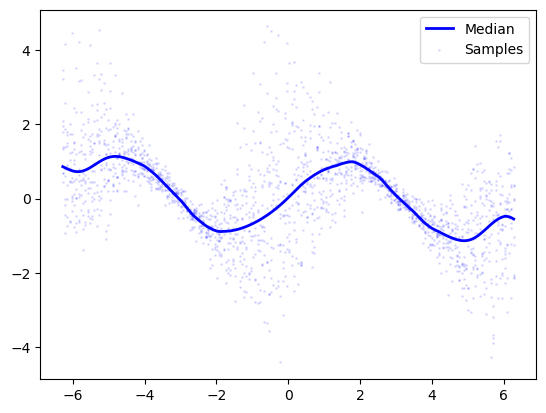

In [17]:
plt.plot(x_plot, median, 'b', label='Median', linewidth=2, zorder=3)
plt.scatter(xplot_rep, samples, s=1, color='b', alpha=0.1, label='Samples', zorder=1)
plt.legend()
plt.show()